*Sy Dusk, February 2022*

# Introduction

The EPA maintains a list of criteria pollutants that it monitors at the county level. Counties must report to the EPA when they are not able to keep their criteria pollutant levels below EPA guidelines. These "nonattaining" counties are more polluted than the EPA allows.

Is there a relationship between these especially polluted counties and their racial makeups? Although some sources have produced summary statistics and simple analysis of this phenomenon to identify environmental racism at work, there has yet to be a statistical analysis of this data. 

I prosose that statistical methods like regression and $\chi^2$ tests can be used to validate these claims with more mathematical rigor. 



# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

## EPA Nonattainment Counties

The EPA makes this data publically available.

Data dictionary [here](https://www3.epa.gov/airquality/greenbook/downld/greenbook_exportdoc.pdf) (see page 4).


*Note: ```nac``` is shorthand for "non-attainment counties.*

In [2]:
url = 'https://drive.google.com/file/d/1b6XSai3Z3xaKEZ2neHW36op8eYUmxhov/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
nac = pd.read_csv(path)
nac.head()

,state,st_abbr,countyname,pollutant,revoked_naaqs,area_name,split,yr1992,yr1993,yr1994,...,effec_rede,nonattain,class,part,population,fips_state,fips_cnty,pollorder,composid,exportdt
0,ALABAMA,AL,Colbert County,Sulfur Dioxide (1971),NaN,"Colbert Co, AL",False,92.0,NaN,NaN,...,3/15/1993,NaN,Secondary,P,54429,1,33,C,SO2.1978.Colbert_Co,3/31/2021
1,ALABAMA,AL,Jackson County,PM-2.5 (1997),NaN,"Chattanooga, TN-GA-AL",False,NaN,NaN,NaN,...,12/22/2014,NaN,Moderate,P,1760,1,71,e,PM-2.5.1997.Chattanooga,3/31/2021
2,ALABAMA,AL,Jefferson County,1-Hour Ozone (1979),Revoked,"Birmingham, AL",False,92.0,93.0,94.0,...,4/12/2004,NaN,Marginal,W,658466,1,73,G,Ozone_1-hr.1990.Birmingham,3/31/2021
3,ALABAMA,AL,Jefferson County,8-Hour Ozone (1997),Revoked,"Birmingham, AL",False,NaN,NaN,NaN,...,6/12/2006,NaN,Former Subpart 1,W,658466,1,73,g,Ozone_8-hr.1997.Birmingham,3/31/2021
4,ALABAMA,AL,Jefferson County,Lead (1978),NaN,"Jefferson Co, AL",False,92.0,93.0,94.0,...,3/7/1995,NaN,NaN,P,658472,1,73,A,Lead.1992.Birmingham,3/31/2021


In [3]:
nac['state'] = nac['state'].str.title() # helpful for joining
nac = nac[nac['revoked_naaqs'].isna()] # drop revoked standards (described in data dict)
cols = ['state', 'countyname', 'pollutant', 'yr2021', 'population', 'nonattain']
nac = nac.loc[:, cols].copy()
nac.head()

,state,countyname,pollutant,yr2021,population,nonattain
0,Alabama,Colbert County,Sulfur Dioxide (1971),NaN,54429,NaN
1,Alabama,Jackson County,PM-2.5 (1997),NaN,1760,NaN
4,Alabama,Jefferson County,Lead (1978),NaN,658472,NaN
5,Alabama,Jefferson County,PM-2.5 (1997),NaN,658466,NaN
6,Alabama,Jefferson County,PM-2.5 (2006),NaN,658466,NaN


In [4]:
nac['nonattain'].value_counts(dropna=False)

NaN    693
Yes    516
Name: nonattain, dtype: int64

Let's rework the ```nonattain``` field to be framed in the positive and give it the boolean dtype. 

In [5]:
nac['attain'] = nac['nonattain'].fillna('No').apply(lambda x: True if x == 'No' else False)
nac = nac.drop('nonattain', axis=1)
nac.dtypes

state          object
countyname     object
pollutant      object
yr2021        float64
population      int64
attain           bool
dtype: object

## Race by County

Data from 2010 census.

In [6]:
url = 'https://drive.google.com/file/d/1rzrLpyjvJB1DjcPnqcusdHLsXB0Ho3st/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
race = pd.read_csv(path, header=1)
race.head()

,id,Geographic Area Name,Total races tallied,Total races tallied!!Not Hispanic or Latino,Total races tallied!!Not Hispanic or Latino!!White alone or in combination with one or more other races,Total races tallied!!Not Hispanic or Latino!!Black or African American alone or in combination with one or more other races,Total races tallied!!Not Hispanic or Latino!!American Indian and Alaska Native alone or in combination with one or more other races,Total races tallied!!Not Hispanic or Latino!!Asian alone or in combination with one or more other races,Total races tallied!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone or in combination with one or more other races,Total races tallied!!Not Hispanic or Latino!!Some Other Race alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino,Total races tallied!!Hispanic or Latino!!White alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino!!Black or African American alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino!!American Indian and Alaska Native alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino!!Asian alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone or in combination with one or more other races,Total races tallied!!Hispanic or Latino!!Some Other Race alone or in combination with one or more other races
0,0500000US01001,"Autauga County, Alabama",55501,54070,42844,9896,530,688,50,62,1431,784,80,35,18,15,499
1,0500000US01003,"Baldwin County, Alabama",185141,176667,154351,17775,2285,1753,139,364,8474,4310,221,151,65,40,3687
2,0500000US01005,"Barbour County, Alabama",27722,26285,12978,12957,165,123,32,30,1437,374,64,59,1,16,923
3,0500000US01007,"Bibb County, Alabama",23126,22696,17342,5106,154,50,14,30,430,206,30,4,4,7,179
4,0500000US01009,"Blount County, Alabama",58029,53284,51497,860,636,205,30,56,4745,2219,49,39,7,21,2410


These fields are unreadable and the values show absolute head counts instead of percentages. 

In [7]:
to_drop = race.columns[2:]

In [8]:
# create clearer columns and convert to percentages
race['White'] = race['Total races tallied!!Not Hispanic or Latino!!White alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!White alone or in combination with one or more other races']
race['White'] = race['White'] / race['Total races tallied']
race['Black'] = race['Total races tallied!!Not Hispanic or Latino!!Black or African American alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!Black or African American alone or in combination with one or more other races']
race['Black'] = race['Black'] / race['Total races tallied']
race['American Indian'] = race['Total races tallied!!Not Hispanic or Latino!!American Indian and Alaska Native alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!American Indian and Alaska Native alone or in combination with one or more other races']
race['American Indian'] = race['American Indian'] / race['Total races tallied']
race['Asian'] = race['Total races tallied!!Not Hispanic or Latino!!Asian alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!Asian alone or in combination with one or more other races']
race['Asian'] = race['Asian'] / race['Total races tallied']
race['Pacific Islander'] = race['Total races tallied!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone or in combination with one or more other races']
race['Pacific Islander'] = race['Pacific Islander'] / race['Total races tallied']
race['Other Race'] = race['Total races tallied!!Not Hispanic or Latino!!Some Other Race alone or in combination with one or more other races'] + race['Total races tallied!!Hispanic or Latino!!Some Other Race alone or in combination with one or more other races']
race['Other Race'] = race['Other Race'] / race['Total races tallied']
# drop messy columns
race = race.drop(to_drop, axis=1).drop('id', axis=1)
race.head()

,Geographic Area Name,White,Black,American Indian,Asian,Pacific Islander,Other Race
0,"Autauga County, Alabama",0.786076,0.179745,0.010180,0.012720,0.001171,0.010108
1,"Baldwin County, Alabama",0.856974,0.097202,0.013158,0.009820,0.000967,0.021881
2,"Barbour County, Alabama",0.481639,0.469699,0.008080,0.004473,0.001731,0.034377
3,"Bibb County, Alabama",0.758800,0.222088,0.006832,0.002335,0.000908,0.009037
4,"Blount County, Alabama",0.925675,0.015665,0.011632,0.003653,0.000879,0.042496


In [9]:
# split State and County
race[['County', 'State']] = race['Geographic Area Name'].str.split(', ', expand=True)
race = race.drop('Geographic Area Name', axis=1)
race.head()

,White,Black,American Indian,Asian,Pacific Islander,Other Race,County,State
0,0.786076,0.179745,0.010180,0.012720,0.001171,0.010108,Autauga County,Alabama
1,0.856974,0.097202,0.013158,0.009820,0.000967,0.021881,Baldwin County,Alabama
2,0.481639,0.469699,0.008080,0.004473,0.001731,0.034377,Barbour County,Alabama
3,0.758800,0.222088,0.006832,0.002335,0.000908,0.009037,Bibb County,Alabama
4,0.925675,0.015665,0.011632,0.003653,0.000879,0.042496,Blount County,Alabama


## Merging the data

*Note: ```poll``` is shorthand for "polluted".*

In [10]:
poll = nac.merge(race, how='left', left_on=['state', 'countyname'], right_on=['State', 'County']).drop(['yr2021', 'population'], axis=1)
poll.head()

,state,countyname,pollutant,attain,White,Black,American Indian,Asian,Pacific Islander,Other Race,County,State
0,Alabama,Colbert County,Sulfur Dioxide (1971),True,0.806079,0.165534,0.011518,0.005515,0.000561,0.010794,Colbert County,Alabama
1,Alabama,Jackson County,PM-2.5 (1997),True,0.909286,0.037604,0.031361,0.004668,0.001208,0.015873,Jackson County,Alabama
2,Alabama,Jefferson County,Lead (1978),True,0.532863,0.420363,0.006171,0.016361,0.000740,0.023502,Jefferson County,Alabama
3,Alabama,Jefferson County,PM-2.5 (1997),True,0.532863,0.420363,0.006171,0.016361,0.000740,0.023502,Jefferson County,Alabama
4,Alabama,Jefferson County,PM-2.5 (2006),True,0.532863,0.420363,0.006171,0.016361,0.000740,0.023502,Jefferson County,Alabama


In [11]:
poll[poll.isna().any(axis=1)]

,state,countyname,pollutant,attain,White,Black,American Indian,Asian,Pacific Islander,Other Race,County,State
328,District Of Columbia,District of Columbia,8-Hour Ozone (2008),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,District Of Columbia,District of Columbia,8-Hour Ozone (2015),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,District Of Columbia,District of Columbia,Carbon Monoxide (1971),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,District Of Columbia,District of Columbia,PM-2.5 (1997),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,Guam,Guam,Sulfur Dioxide (1971),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,Guam,Guam,Sulfur Dioxide (1971),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,Guam,Guam,Sulfur Dioxide (2010),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1024,Puerto Rico,Bayamon Municipio,Sulfur Dioxide (2010),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1025,Puerto Rico,Catano Municipio,Sulfur Dioxide (2010),False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears that we don't have data for certain special US counties. We'll drop these rows.

In [12]:
poll = poll.dropna()
poll = poll.drop(['countyname', 'state'], axis=1)

### Tidying the merged data

In [13]:
poll['pollutant'].unique()

array(['Sulfur Dioxide (1971)', 'PM-2.5 (1997)', 'Lead (1978)',
       'PM-2.5 (2006)', 'Lead (2008)', 'Carbon Monoxide (1971)',
       'PM-10 (1987)', '8-Hour Ozone (2015)', 'Sulfur Dioxide (2010)',
       '8-Hour Ozone (2008)', 'PM-2.5 (2012)', 'Nitrogen Dioxide (1971)'],
      dtype=object)

In [14]:
# use the latest standards for criteria pollutants
to_keep = ['Lead (2008)', 'Carbon Monoxide (1971)', 'PM-10 (1987)', '8-Hour Ozone (2015)', 
           'Sulfur Dioxide (2010)', 'PM-2.5 (2012)', 'Nitrogen Dioxide (1971)']
poll = poll.loc[poll['pollutant'].isin(to_keep), :]

In [15]:
# some counties are nonattaining for multiple pollutants; group them 
poll = poll.groupby(['State', 'County']).agg('first').drop('pollutant', axis=1)
poll

attain     White     Black  \
State     County                                                     
Alabama   Pike County                     True  0.584713  0.367761   
Alaska    Anchorage Municipality          True  0.667593  0.070701   
          Fairbanks North Star Borough    True  0.775025  0.056826   
          Juneau City and Borough         True  0.701127  0.017086   
Arizona   Cochise County                 False  0.785312  0.050182   
...                                        ...       ...       ...   
Wisconsin Milwaukee County               False  0.611365  0.275161   
          Oneida County                  False  0.965823  0.006358   
          Ozaukee County                 False  0.948104  0.017356   
          Sheboygan County               False  0.898616  0.019681   
Wyoming   Sheridan County                 True  0.953321  0.005645   

                                        American Indian     Asian  \
State     County                                                    
Alabama   Pike County                          0.012570  0.022147   
Alaska    Anchorage Municipality               0.113347  0.094441   
          Fairbanks North Star Borough         0.101847  0.039687   
          Juneau City and Borough              0.173020  0.082116   
Arizona   Cochise County                       0.021809  0.029394   
...                                                 ...       ...   
Wisconsin Milwaukee County                     0.014031  0.038321   
          Oneida County                        0.016691  0.006989   
          Ozaukee County                       0.005339  0.021552   
          Sheboygan County                     0.007968  0.048794   
Wyoming   Sheridan County                      0.020044  0.009836   

                                        Pacific Islander  Other Race  
State     County                                                      
Alabama   Pike County                           0.001077    0.011732  
Alaska    Anchorage Municipality                0.025312    0.028606  
          Fairbanks North Star Borough          0.007405    0.019209  
          Juneau City and Borough               0.011986    0.014666  
Arizona   Cochise County                        0.005799    0.107505  
...                                                  ...         ...  
Wisconsin Milwaukee County                      0.001170    0.059952  
          Oneida County                         0.000822    0.003316  
          Ozaukee County                        0.000823    0.006826  
          Sheboygan County                      0.000775    0.024167  
Wyoming   Sheridan County                       0.001656    0.009498  

[335 rows x 7 columns]

# Visualizing Racial Composition

Let's look at the distributions of various races across all counties.

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

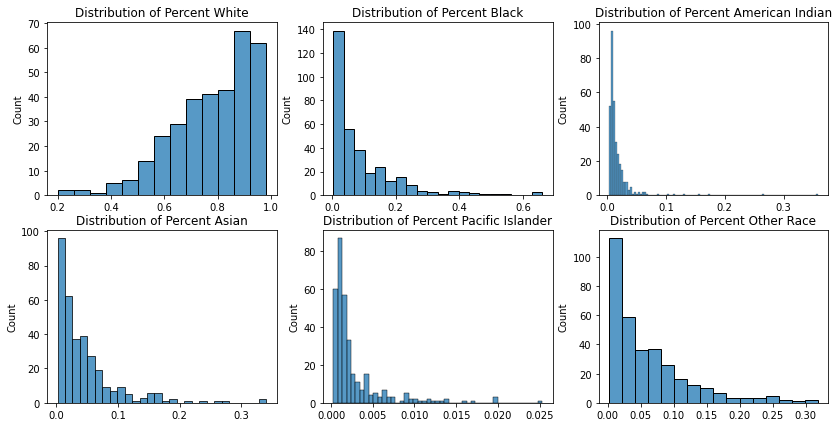

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))

for col, ax in zip(poll.columns[1:], np.ndarray.flatten(axs)):
    sns.histplot(data=poll, x=col, ax=ax).set(title=f'Distribution of Percent {col}')
    ax.set_xlabel('');

We can see that all these didstributions are quite skewed. This shows that there are many counties that are majority white but only a few that are not. 

Let's look at the distribution of percent of white people broken up by EPA attainment status.

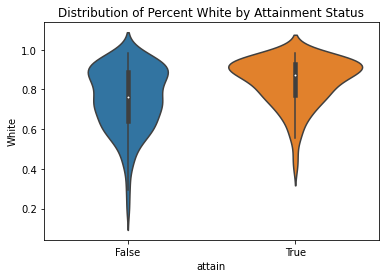

In [18]:
sns.violinplot(data=poll, y='White', x='attain').set(title='Distribution of Percent White by Attainment Status');

A few observations:

* There is a lot of overlap between the groups but the mean percent White of attaining (nonpolluted) counties is much higher then in nonattaining (polluted) counties and the whole distribution is clustered more tightly around that higher mean. 
* There is much more variation in percent White population among nonattaining counties.
* Majority non-White counties are few in number but seem to be disproportionately nonattaining (polluted).

# Regression Analysis

Since we are looking at the effects of a continuous variable on a binary output and would like to interpret the relationship with statistical rigor, I will use Logistic Regression. 

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X, y = poll.drop('attain', axis=1), poll['attain']

pipe = Pipeline([('scaler', StandardScaler()), ('log_regr_clf', LogisticRegressionCV())])

pipe.fit(X, y)
pipe.score(X, y)

0.6955223880597015

Interestingly, given only the racial makeup of a county the classifier can correctly predict the EPA attainment status in 70% of cases. 

In [20]:
pipe['log_regr_clf'].coef_

array([[ 0.00401785, -0.00275276,  0.00123641, -0.00259751,  0.00124072,
        -0.00343246]])

Notably, from comparing the model coefficients, percent of White poeple in a county is the strongest predictor of EPA attainment status, followed by percent of other races. This suggests that there is a notable association between racial composition of a county and its EPA attainment status. Let's bring more statistical rigor to bear on this relationship. 

# $\chi^2$ test of independence

This test is used to compare counts across two categories by calculating the chance of seeing those counts if the categories were independent. It is a generalization of Fisher's exact test for 2x2 contingency tables to any size table.

The null hypothesis is that there is no dependancy between percent of White people in a county and the county's EPA attainment status.

The alternate is that there is a dependent relationship. 

We'll need to define categorical bins and then crosstabulate to run this test.

In [21]:
# I chose 10 bins to give enough granularity without making too many categories
poll['Percentage White Category'] = pd.cut(poll['White'], bins=10, labels=list(range(1,11)))
poll

attain     White     Black  \
State     County                                                     
Alabama   Pike County                     True  0.584713  0.367761   
Alaska    Anchorage Municipality          True  0.667593  0.070701   
          Fairbanks North Star Borough    True  0.775025  0.056826   
          Juneau City and Borough         True  0.701127  0.017086   
Arizona   Cochise County                 False  0.785312  0.050182   
...                                        ...       ...       ...   
Wisconsin Milwaukee County               False  0.611365  0.275161   
          Oneida County                  False  0.965823  0.006358   
          Ozaukee County                 False  0.948104  0.017356   
          Sheboygan County               False  0.898616  0.019681   
Wyoming   Sheridan County                 True  0.953321  0.005645   

                                        American Indian     Asian  \
State     County                                                    
Alabama   Pike County                          0.012570  0.022147   
Alaska    Anchorage Municipality               0.113347  0.094441   
          Fairbanks North Star Borough         0.101847  0.039687   
          Juneau City and Borough              0.173020  0.082116   
Arizona   Cochise County                       0.021809  0.029394   
...                                                 ...       ...   
Wisconsin Milwaukee County                     0.014031  0.038321   
          Oneida County                        0.016691  0.006989   
          Ozaukee County                       0.005339  0.021552   
          Sheboygan County                     0.007968  0.048794   
Wyoming   Sheridan County                      0.020044  0.009836   

                                        Pacific Islander  Other Race  \
State     County                                                       
Alabama   Pike County                           0.001077    0.011732   
Alaska    Anchorage Municipality                0.025312    0.028606   
          Fairbanks North Star Borough          0.007405    0.019209   
          Juneau City and Borough               0.011986    0.014666   
Arizona   Cochise County                        0.005799    0.107505   
...                                                  ...         ...   
Wisconsin Milwaukee County                      0.001170    0.059952   
          Oneida County                         0.000822    0.003316   
          Ozaukee County                        0.000823    0.006826   
          Sheboygan County                      0.000775    0.024167   
Wyoming   Sheridan County                       0.001656    0.009498   

                                       Percentage White Category  
State     County                                                  
Alabama   Pike County                                          5  
Alaska    Anchorage Municipality                               6  
          Fairbanks North Star Borough                         8  
          Juneau City and Borough                              7  
Arizona   Cochise County                                       8  
...                                                          ...  
Wisconsin Milwaukee County                                     6  
          Oneida County                                       10  
          Ozaukee County                                      10  
          Sheboygan County                                     9  
Wyoming   Sheridan County                                     10  

[335 rows x 8 columns]

In [22]:
table = pd.crosstab(poll['Percentage White Category'], poll['attain'])
table

attain,False,True
Percentage White Category,,
1,2,0
2,3,0
3,4,1
4,7,1
5,21,3
6,31,5
7,42,11
8,33,19
9,45,27


In [23]:
# the actual test
from scipy import stats

stat, p, dof, exp = stats.chi2_contingency(table)
p

0.004956907700652312

With such a low p-value it is statistically unlikely that attainment status is independent from percentage of white people in a county. We can safely reject the null hypothesis. 

# Conclusion

A $\chi^2$ test of independence revealed that there is in fact an association between the racial makeup of a county and its EPA attainment status. A regression analysis showed that a logistic regression classifier can correctly predict the attainment status of a county given only its racial composition 70% of the time. 

Clearly EPA attainment status is related to race. This statistical analysis supports the claims of environmental racism. 